## Deep Dreaming using Tensorflow

Deepdream is image modification alogorithm that uses representation learned by convolution neural networks to modify images. It was released by google in 2015. The popularity of deepdream caused due to its crappy artifacts in images, from eyes to feathers to dog faces. It was initially created to help scientists and engineers to see what a deep neural network is seeing when it is looks given input.

Deepdream is based on one of the technique of visualizing learnings of convnets. Using that technique we can visualize patterns that activates given layer of convolutional neural network or visual pattern that each filter respond to in convolutional layers. This is done by applying gradient ascent in input space, which maximizes response of specific filter in convnets.

### Gradient Ascent

gradient ascent is opposite of gradient descent. Both are optimization algorithms. As gradient descent finds out minima of a function gradient ascent finds out maxima of a function. The process of gradient ascent is same as gradient descent we first find out gradient(derivative) of function with respect to our training parameters and then change training parameters so as to maximize instead of minimizing by moving it in opposite direction of gradient descent. 

For visualizing patterns learned by convnets we have to maximize response of specific filters. In simple words we have response(activations) of specific filter in a convolutional layer and we change our input space so as to maximize that filter's response by using gradient ascent.

### Steps to create Deepdream

- we start with a image and pass it to a pretrained convolutional neural network like inception or vgg
- we try to maximize activation of entire layer rather than specific filter for this we define a simple loss function which will maximize activations of layers on maximizing that loss function. So we use mean of activations of layers as loss function.
- finally we will change our input space(image) by applying that gradient to image which eventually will maximize out loss function.
- additional steps like tiling and octaves are needed in order to work with large images so that it can be fit efficiently
on RAM and provide better results.

Implementing deepdream teaches a lot of other concepts of deep learning. It breaks the rule of traditional *model.fit* in every deep learning problem. Also playing with result is quite intresting so get ready for deepdream.

In [3]:
input_img_path="starry.jpg"

Starting with our input image in which deepdream patterns will be shown as output. First we will define path of our input image.

In [4]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import inception_v3
from tensorflow.keras.models import load_model,Model
from PIL import Image
import IPython.display as display
import time

Next we will import all dependencies which we will need for creating deepdream. 

- **numpy :** for arrays manipulation
- **tensorflow :** for tensor operations
- **tensorflow.keras :** high level neural network library for tensorflow for creating neural networks
- **pillow :** for converting an image to numpy array and numpy array to image, saving out output image.
- **Ipython.display :** for displaying images in notebook
- **time :** for calculating time of each iteration

We are using Inception pretrained model for this as it produces better outputs of deepdreams and original implementation also used Inception model.

> Dreams in Inception movie.😁😁

In [5]:
def load_image(image_path,max_dim=512):
    img=Image.open(image_path)
    img=img.convert("RGB")
    img.thumbnail([max_dim,max_dim])
    img=np.array(img,dtype=np.uint8)
    img=np.expand_dims(img,axis=0)
    return img

the above function 
- loads image from path
- convert it into RGB format
- resize it with max dimension specified while maintaining aspect ratio
- converting image to numpy array and creating batch of single image since neural networks expects the input to be in batches. 

In [6]:
def deprocess_inception_image(img):
    img = 255*(img+1.0)/2.0
    return np.array(img, np.uint8)

the above function cancels out effects of preprocessing applied by inception's preprocess_input function. preprocess_input function for inception model scales down pixels of image to be in range -1 to 1 so this function will scale pixels to be in range 0 to 255

In [7]:
def array_to_img(array,deprocessing=False):
    if deprocessing:
        array=deprocess_inception_image(array)
    if np.ndim(array)>3:
        assert array.shape[0]==1
        array=array[0]
    return Image.fromarray(array)

the above function will convert array to image. if deprocessing is true it will first deprocess inception preprocessing and then convert array to image

In [8]:
def show_image(img):
    image=array_to_img(img)
    display.display(image)

the above function will show image in notebook by first converting array to image

(1, 338, 512, 3)


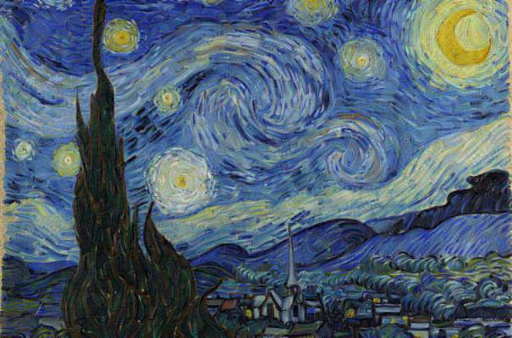

In [9]:
input_image=load_image(input_img_path,max_dim=512)
print(input_image.shape)
show_image(input_image)

Now lets load our input image and display it.

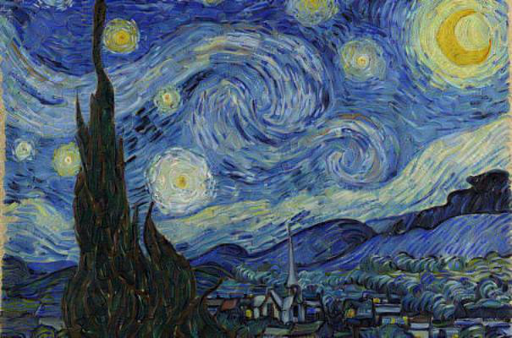

In [10]:
preprocessed_image=inception_v3.preprocess_input(input_image)
show_image(deprocess_inception_image(preprocessed_image))

Also check if our deprocess_image function is working as expected

In [11]:
def deep_dream_model(model,layer_names):
    model.trainable=False
    outputs=[model.get_layer(name).output for name in layer_names]
    new_model=Model(inputs=model.input,outputs=outputs)
    return new_model

the above function creates a deepdream model. Since we are not training our model so set trainable to false. Our deepdream model takes input as image and outputs the activations of layers which we will use to embed patterns learned by that layers into our input image

In [12]:
inception=inception_v3.InceptionV3(weights="imagenet",include_top=False)
inception.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, None, None, 3 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, None, None, 3 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, None, None, 3 0           batch_normalization[0][0]        
_______________________________________________________________________________________

activation_79 (Activation)      (None, None, None, 3 0           batch_normalization_79[0][0]     
__________________________________________________________________________________________________
activation_82 (Activation)      (None, None, None, 3 0           batch_normalization_82[0][0]     
__________________________________________________________________________________________________
activation_83 (Activation)      (None, None, None, 3 0           batch_normalization_83[0][0]     
__________________________________________________________________________________________________
batch_normalization_84 (BatchNo (None, None, None, 1 576         conv2d_84[0][0]                  
__________________________________________________________________________________________________
activation_76 (Activation)      (None, None, None, 3 0           batch_normalization_76[0][0]     
__________________________________________________________________________________________________
mixed9_0 (

Now since we are using inception model so lets create a inception model using keras and print its layers

In [13]:
layers_contributions=['mixed3', 'mixed5']

Lets describe layers whose patterns we want to embed into our input image. Here we are using *mixed3* and *mixed5* layers which are concatenation of different convolution layers.

In [14]:
dream_model=deep_dream_model(inception,layers_contributions)

Now we will create dream model using *deep_dream_model* function which we had defined earlier

In [15]:
deep_outputs=dream_model(preprocessed_image)
for layer_name,outputs in zip(layers_contributions,deep_outputs):
    print(layer_name)
    print(outputs.shape)
    print(outputs.numpy().mean())

mixed3
(1, 19, 30, 768)
0.44434533
mixed5
(1, 19, 30, 768)
0.16857202


Lets test how we can extract and manipulate activations of layers which we have defined in *layers_contributions* using our deep dream model

In [16]:
model_output= lambda model,inputs:model(inputs)

Now lets define a helper function which will return output of model on providing input. Above we have defined a *lambda* function which takes model and input image as parameter and return output of model *ie..*  activations of layers which we have defined in *layers_contributions*

In [17]:
def get_loss(activations):
    loss=[]
    for activation in activations:
        loss.append(tf.math.reduce_mean(activation))
    return tf.reduce_sum(loss)

the above function defines our loss function which we will maximize using gradient ascent. It is simply sum of mean of activations

In [18]:
def get_loss_and_gradient(model,inputs,total_variation_weight=0):
    with tf.GradientTape() as tape:
        tape.watch(inputs)
        activations=model_output(model,inputs)
        loss=get_loss(activations)
        loss=loss+total_variation_weight*tf.image.total_variation(inputs)
    grads=tape.gradient(loss,inputs)
    grads /= tf.math.reduce_std(grads) + 1e-8 
    return loss,grads

the above function returns gradient (derivative) of our loss function with respect to our input image. We use tensoflow *GradientTape* to calculate gradients. First we have to watch our input image since it is not tensorflow variable then we get our model outputs which are activations of layers in *layers_contributions* and we will use these activations to find loss and finally find out gradient using *tape.gradient* method we also standarize our gradients by dividing it with standard deviation of gradients. A small number *1e-8* is also added to prevent accidently division by 0.

There is also *total_variation_weight* parameter this will be used for adding some amount of *total_variation* loss into our loss function.

The total variation loss is the sum of the absolute differences for neighboring pixel-values in the input images. This measures how much noise is in the images.

*total variation loss* is not necessary for deep dream outputs but can be used to smooth out result. play with *total_variation_weight* parameter to find result of your liking.

In [21]:
def run_gradient_ascent(model,inputs,epochs=1,steps_per_epoch=1,weight=0.01,total_variation_weight=0):
    img = tf.convert_to_tensor(inputs)
    start=time.time()
    for i in range(epochs):
        print(f"epoch: {i+1}",end=' ')
        for j in range(steps_per_epoch):
            loss,grads=get_loss_and_gradient(model,img,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
            print('=',end='')
        print("\n")
    end=time.time()
    print(f"Time elapsed: {end-start:1f}sec")
    return img.numpy()

Now we have gradients of loss with respect to input image, we define a function that will do gradient ascent by changing our input image in direction of gradients. This will maximize input space which will eventually increase activations of layers.
This function also takes *epochs* as parameter which is number of iteration for which we want to process image. *weight* parameter is strength of patterns embed to image. Method also prints stats of each epoch

In [39]:
image_array=run_gradient_ascent(dream_model,preprocessed_image,epochs=2,steps_per_epoch=100,weight=0.01)

epoch: 1 ====================================================================================================

epoch: 2 ====================================================================================================

Time elapsed: 62.779686sec


Now its time to create deep dream image, we apply gradient ascent for some epochs and save our image into a variable which is a numpy array

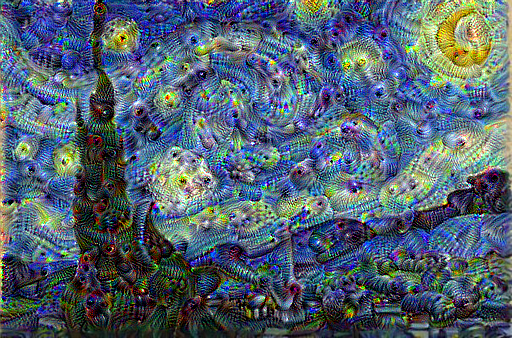

In [40]:
show_image(deprocess_inception_image(image_array))
resultant_image=array_to_img(image_array,True)
resultant_image.save("deep_dream_simple.jpg")

Now we are ready to see how our input image looks like. We first deprocess our numpy array and then convert it to image and finally save output image to hard drive as image.

## Deep Dreaming using octaves

To improve quality of patterns in image we can use octaves technique. In this technique input image is processed at different scale. Each different size image is an octave this improve quality of patterns on image.

### Steps:
- first base shape of image is saved to a variable
- input image is then scaled to different sizes smaller and greater than base shape
- these octaves (different scaled images) are then passed to *run_gradient_ascent* function to apply gradient ascent to each octave.
- finally resultant image is again resized to base shape

In [24]:
def run_gradient_ascent_with_octaves(model,inputs,epochs=1,steps_per_epoch=1,num_octaves=2,octave_size=1.3,weight=0.01,total_variation_weight=0):
    img=tf.convert_to_tensor(inputs)
    assert len(inputs.shape)<=4 or len(inputs.shape)>=3
    if len(inputs.shape)==3:
        base_shape=img.shape[:-1]
    base_shape=img.shape[1:-1]
    for n in range(-num_octaves,1):
        print(f'Processing Octave: {n*-1}')
        new_shape=tuple([int(dim * (octave_size**n)) for dim in base_shape])
        img=tf.image.resize(img,new_shape)
        img=run_gradient_ascent(model,img,epochs,steps_per_epoch,weight,total_variation_weight)
    return tf.image.resize(img,base_shape).numpy()

the above function runs gradient ascent using octave technique. It takes *num_octaves* parameter which is number of octaves you want to process. Default is 2 that means it process 2 octaves and 1 original image. 

Image is resized using tensorflow *image.resize* function. New shape is calculated by raising height and width of image to power of octave number to process. As you can notice loops starts from *-num_octaves to 0 (excluding 1)*. Negative power will scale down the image from its base shape. We can also run loop from *-num_octaves to +num_octave* but as image size increases it consume more RAM. 

*octave_size* parameter tells by what factor we want to scale images 

In [37]:
image_array=run_gradient_ascent_with_octaves(dream_model,preprocessed_image,epochs=1,steps_per_epoch=100,num_octaves=3,octave_size=1.3,weight=0.01)

Processing Octave: 3
epoch: 1 ====================================================================================================

Time elapsed: 25.796944sec
Processing Octave: 2
epoch: 1 ====================================================================================================

Time elapsed: 27.048554sec
Processing Octave: 1
epoch: 1 ====================================================================================================

Time elapsed: 27.536671sec
Processing Octave: 0
epoch: 1 ====================================================================================================

Time elapsed: 31.441849sec


Now its time to create deep dream image, It takes more time to create deep dream but it worth.

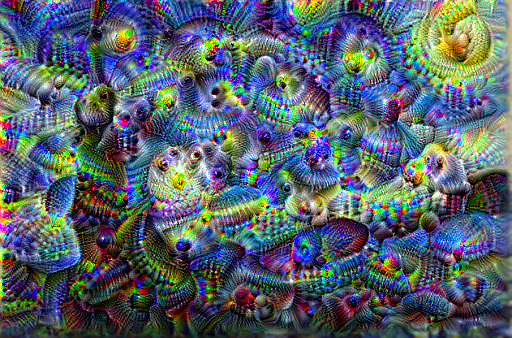

In [38]:
show_image(deprocess_inception_image(image_array))
image=array_to_img(image_array,True)
image.save("deep_dream_with_octave.jpg")

And this time we got some exciting results.

## Deep Dreaming using Image Tiling

As we start processing bigger images we need more RAM to put it into memory for calculating gradients. Also we cannot process more octaves using above techniques. 

This issue can be fixed by using image tilings, In this technique we split image into tiles and gradient is calculated for each tile seperately. 

By tiling images into small sizes and processing these tiles solves the issue as we have to process small tiles of image not the entire image.

While tiling we make sure that it is random else we get seam in our image after processing.

In [31]:
# Randomly rolls the image to avoid tiled boundaries.
def random_image_tiling(img, maxdim):
    shift = tf.random.uniform(shape=[2], minval=-maxdim, maxval=maxdim, dtype=tf.int32)
    shift_r,shift_d=shift
    img_rolled = tf.roll(img, shift=[shift_r,shift_d], axis=[1,0])
    return shift_r, shift_d, img_rolled

the above function takes image as input and randomly rolls the image to avoid tiled boundaries. It returns shifted image and positions from where image was shifted. We have used tensorflow *roll* function to shift images. It create roll of an array along different axis from shift positions specified.

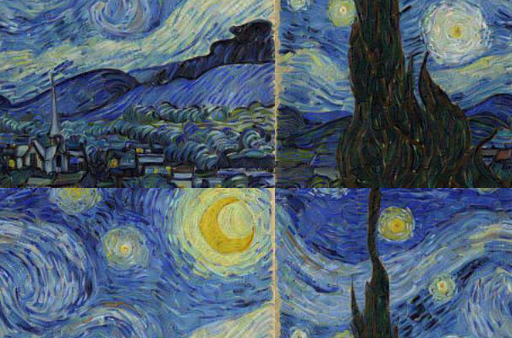

In [32]:
shift_r,shift_d,img_tiled=random_image_tiling(input_image[0], 512)
show_image(img_tiled.numpy())

lets test of how random tiled image function transforms our image and randomly roll it so that we do not get same tile everytime we process and seam across image.

In [33]:
def get_loss_and_grads_with_tiling(model,inputs,tile_size=512,total_variation_weight=0.004):
    shift_r,shift_d,rolled_image=random_image_tiling(inputs[0],tile_size)
    grads=tf.zeros_like(rolled_image)
    # create a tensor from 0 to rolled_image width with step of tile size
    x_range = tf.range(0, rolled_image.shape[0], tile_size)[:-1]
    # check if x_range is not empty
    if not tf.cast(len(x_range), bool):
        x_range= tf.constant([0])
    # create a tensor from 0 to rolled_image height with step of tile size
    y_range = tf.range(0, rolled_image.shape[1], tile_size)[:-1] 
    # check if y_range is not empty
    if not tf.cast(len(y_range), bool):
        y_range=tf.constant([0])
    for x in x_range:
        for y in y_range:
            with tf.GradientTape() as tape:
                tape.watch(rolled_image)
                # here we create tile from rolled image of size=tile_size
                image_tile= tf.expand_dims(rolled_image[x:x+tile_size, y:y+tile_size],axis=0)
                activations=model_output(model,image_tile)
                loss=get_loss(activations)
                loss=loss+total_variation_weight*tf.image.total_variation(image_tile) 
            grads=grads+tape.gradient(loss,rolled_image)
    grads = tf.roll(grads, shift=[-shift_r,-shift_d], axis=[1,0]) #reverse shifting of rolled image
    grads /= tf.math.reduce_std(grads) + 1e-8
    return loss,grads

Lets define a way to get gradients from tiled image. In above function we first get random rolled image and its rolling positions using *random_image_tiling* function. We then have some logic to create a tile from rolled image of size *tile_size* specified. This tile image is then passed to model and loss is calculated finally gradients are calculated for that tile and added to *grads* tensor. We process small tiles of rolled image till we have iterated whole image (rolled image) and all gradients of each tile are summed together. Then we reverse the shiftings of rolled image back to original image and finally scaling and returning the graadients.

In [34]:
def run_gradient_ascent_with_octave_tiling(model,inputs,steps_per_octave=100,num_octaves=2,octave_size=1.3,tile_size=512,weight=0.01,total_variation_weight=0.0004):
    img=tf.convert_to_tensor(inputs)
    weight=tf.convert_to_tensor(weight)
    assert len(inputs.shape)<=4 or len(inputs.shape)>=3
    if len(inputs.shape)==3:
        base_shape=img.shape[:-1]
    base_shape=img.shape[1:-1]
    start=time.time()
    for n in range(-num_octaves,num_octaves+1):
        print(f'Processing Octave: {n+num_octaves+1}')
        new_shape=tuple([int(dim*(octave_size**n)) for dim in base_shape])
        img=tf.image.resize(img,new_shape)
        for step in range(steps_per_octave):
            print('=',end='')
            loss,grads=get_loss_and_grads_with_tiling(model,img,tile_size,total_variation_weight)
            img = img + grads*weight
            img = tf.clip_by_value(img, -1.0, 1.0)
        print("\n")
    end=time.time()
    print(f"Time elapsed: {end-start:.1f} sec")
    return tf.image.resize(img, base_shape).numpy()

the above funtion is same as *run_gradient_ascent_with_octave* but instead of using *get_loss_and_grads* function here we have used *get_loss_and_grads_with_tiling* to get gradients using tiling images strategy.

In [35]:
image_array=run_gradient_ascent_with_octave_tiling(dream_model,preprocessed_image,steps_per_octave=100,num_octaves=3,octave_size=1.3,tile_size=512,weight=0.01,total_variation_weight=0)

Processing Octave: 1

Processing Octave: 2

Processing Octave: 3

Processing Octave: 4

Processing Octave: 5

Processing Octave: 6

Processing Octave: 7

Time elapsed: -270.3 sec


Now its time to create deep dream image. Time taken to create dream depends on size of input image passed. It also uses octave technique previously discussed to imporove quality of image but now we can process more octaves.

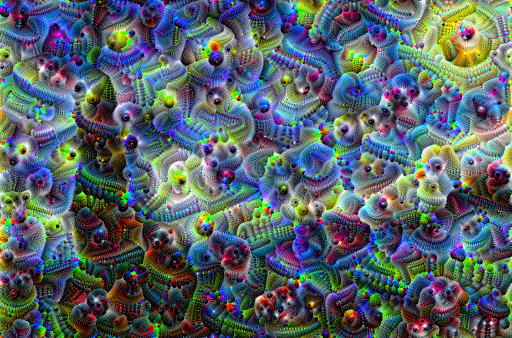

In [36]:
show_image(deprocess_inception_image(image_array))
image=array_to_img(image_array,True)
image.save("deep_dream_with_octave_tiling.jpg")

and this time we got some more exicting results also we can create bigger resolution dream.

So finally we are ready to see some deep dreams of neural networks. Play with it and share exciting results.

Thanks for reading till last. ✌✌✌